In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pip install -q decorator==5.0.9
!pip install -q ipywidgets

import re
import imp
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q cltk==1.0.22

Note: you may need to restart the kernel to use updated packages.


In [4]:
# importing local modules

import sys
sys.path.append('../src/')

import text_cleanup.text_cleanup as thesisCleanUp
import preprocessing.text_preprocessing as thesisTextPreprocessing
import data.reader as thesisDataReader
import utils.utils as thesisUtils
import features.tf_idf.n_gram as thesisTfIdfNgramFeatures
import features.count_vectorizer.n_gram as thesisCountVectorizerNgramFeatures
import similarities.cosine as thesisCosineSimilarities
import vocabulary.vocabulary as thesisVocabulary
import features.lexical as thesisLexicalFeatures
import similarities.cosine as thesisCosineSimilarity
import text_cleanup.text_cleanup as thesisTextCleanUp
import p_aligment.p_aligment as thesisPAligment

imp.reload(thesisLexicalFeatures)
imp.reload(thesisCosineSimilarity)
imp.reload(thesisCleanUp)
imp.reload(thesisTextPreprocessing)
imp.reload(thesisDataReader)
imp.reload(thesisUtils)
imp.reload(thesisTfIdfNgramFeatures)
imp.reload(thesisVocabulary)
imp.reload(thesisCosineSimilarities)
imp.reload(thesisTextCleanUp)
imp.reload(thesisCountVectorizerNgramFeatures)
imp.reload(thesisPAligment)

<module 'p_aligment.p_aligment' from '../src/p_aligment/p_aligment.py'>

# p aligment without most similar above by threshold

#### load data

In [5]:
SIMILARITY_SCORE_UPPER_THRESHOLD = 0.8

N_GRAM_RANGE_FOR_SHARED_VOCABULARY_FROM = 36
N_GRAM_RANGE_FOR_SHARED_VOCABULARY_TO = 29

BIDIRECTIONAL_SIMILARITY_THRESHOLD = 0.5

In [6]:
LONDON_INDEXES_TO_REMOVE_SET = set()
ZWICKAU_INDEXES_TO_REMOVE_SET = set()

In [7]:
london_zwickau_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    thesisDataReader.get_london_by_new_line(),
    thesisDataReader.get_zwickau_by_new_line(),
)
# with open('../computed_data/similarities/cross_version/best_similarities/by_new_line/london_zwickau.json', 'w') as f:
#     json.dump(london_zwickau_original_best_similarities, f)

In [ ]:
# input_file = open('../computed_data/similarities/cross_version/best_similarities/by_new_line/london_zwickau.json')
# london_zwickau_original_best_similarities = json.load(input_file)

In [8]:
zwickau_london_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    thesisDataReader.get_zwickau_by_new_line(),
    thesisDataReader.get_london_by_new_line(),
)
# with open('../computed_data/similarities/cross_version/best_similarities/by_new_line/zwickau_london.json', 'w') as f:
#     json.dump(zwickau_london_original_best_similarities, f)

In [ ]:
# input_file = open('../computed_data/similarities/cross_version/best_similarities/by_new_line/zwickau_london.json')
# zwickau_london_original_best_similarities = json.load(input_file)

In [ ]:
# london_breslau_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     thesisDataReader.get_london_by_new_line(),
#     thesisDataReader.get_breslau_by_new_line(),
# )
# with open('../computed_data/similarities/cross_version/best_similarities/by_new_line/london_breslau.json', 'w') as f:
#     json.dump(london_breslau_original_best_similarities, f)

In [ ]:
# input_file = open('../computed_data/similarities/cross_version/best_similarities/by_new_line/london_breslau.json')
# london_breslau_original_best_similarities = json.load(input_file)

In [ ]:
# zwickau_breslau_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     thesisDataReader.get_zwickau_by_new_line(),
#     thesisDataReader.get_breslau_by_new_line(),
# )
# with open('../computed_data/similarities/cross_version/best_similarities/by_new_line/zwickau_breslau.json', 'w') as f:
#     json.dump(london_breslau_original_best_similarities, f)

In [ ]:
# input_file = open('../computed_data/similarities/cross_version/best_similarities/by_new_line/zwickau_breslau.json')
# zwickau_breslau_original_best_similarities = json.load(input_file)

#### original data

In [9]:
def plot_original_similarities():
    fig, ax = plt.subplots(figsize=(35, 5))

    ax.plot([i['5_gram'][1] for i in london_zwickau_original_best_similarities], label="london_zwickau original")
    ax.plot([i['5_gram'][1] for i in zwickau_london_original_best_similarities], label="zwickau_london original")

    ax.set_ylim([0,1])
    ax.set_xlim([-5,325])
    ax.legend()
    plt.title('Max cross similarity per p')
    plt.show()

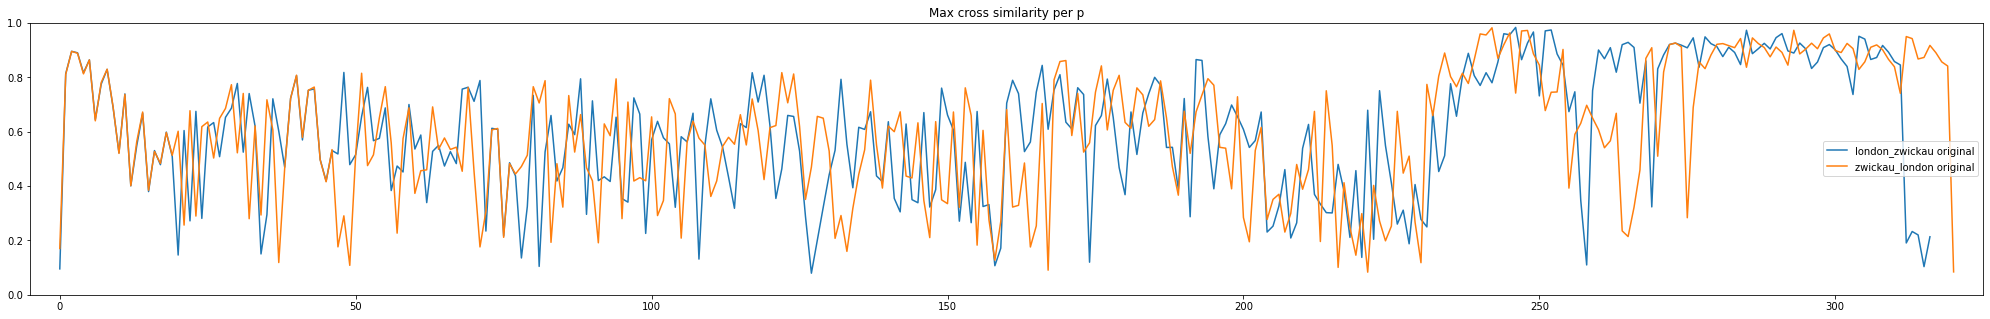

In [10]:
plot_original_similarities()

In [11]:
def create_best_match_by_text_map(
    original_corpus, 
    original_best_similarites, 
    without_strong_similar_corpus, 
    without_strong_similar_best_match
):
    best_match_by_text_map = {}
    
    for p_index, text in enumerate(original_corpus):
        best_match_by_text_map[text] = {
            'original': {
                'index': p_index,
                'best_match': original_best_similarites[p_index]
            }
        }
    
    for p_index, text in enumerate(without_strong_similar_corpus):
                best_match_by_text_map[text] = {
                    **best_match_by_text_map[text],
                    'without_strong_similar': {
                        'index': p_index,
                        'best_match': without_strong_similar_best_match[p_index]
                    }
                }
    
    return best_match_by_text_map

In [12]:
def create_similarities_with_mock_for_drop(original_corpus, best_match_by_p_map):
    mock = []
    for index, text in enumerate(original_corpus):
        text_info = best_match_by_p_map[text]
        similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
        mock.append(similarity_score)

    return mock

#### remove p by threshold and same index

In [13]:
def find_candidate_p_to_remove_by_score_or_index(original_best_similarities):
    p_to_remove = []
    
    for i, s in enumerate(original_best_similarities):
        if s['5_gram'][1] > SIMILARITY_SCORE_UPPER_THRESHOLD: #or s['5_gram'][0] == i:
            p_to_remove.append(i)
    
    return p_to_remove

In [14]:
def remove_p_by_indexes(corpus, indexes_to_remove):
    return [p for i, p in enumerate(corpus) if i not in indexes_to_remove]

In [ ]:
london_zwickau_p_to_remove_by_score_or_index = find_candidate_p_to_remove_by_score_or_index(london_zwickau_original_best_similarities)
LONDON_INDEXES_TO_REMOVE_SET = LONDON_INDEXES_TO_REMOVE_SET.union(set(london_zwickau_p_to_remove_by_score_or_index))
len(london_zwickau_p_to_remove_by_score_or_index)

In [ ]:
print(sorted(LONDON_INDEXES_TO_REMOVE_SET))

In [ ]:
zwickau_london_p_to_remove_by_score_or_index = find_candidate_p_to_remove_by_score_or_index(zwickau_london_original_best_similarities)
ZWICKAU_INDEXES_TO_REMOVE_SET = ZWICKAU_INDEXES_TO_REMOVE_SET.union(set(zwickau_london_p_to_remove_by_score_or_index))
len(zwickau_london_p_to_remove_by_score_or_index)

In [ ]:
print(sorted(ZWICKAU_INDEXES_TO_REMOVE_SET))

In [ ]:
for i in london_zwickau_p_to_remove_by_score_or_index:
    london_zwickau_best_match = london_zwickau_original_best_similarities[i]['5_gram']
    zwickau_p = london_zwickau_best_match[0]

    related_zwickau = zwickau_london_original_best_similarities[zwickau_p]
    if london_zwickau_best_match[0] not in zwickau_london_p_to_remove_by_score_or_index:
        print(f'found london {i} without zwickau: {london_zwickau_original_best_similarities[i]}')
        print(f'related zwickau is: {related_zwickau}')

In [ ]:
london_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_london_by_new_line(), list(LONDON_INDEXES_TO_REMOVE_SET))
zwickau_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_zwickau_by_new_line(), list(ZWICKAU_INDEXES_TO_REMOVE_SET))

In [ ]:
print(len(thesisDataReader.get_london_by_new_line()))
print(len(london_corpus_without_strong_similar))

In [ ]:
print(len(thesisDataReader.get_zwickau_by_new_line()))
print(len(zwickau_corpus_without_strong_similar))

In [ ]:
london_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_london_by_new_line(),
    create_best_match_by_text_map(
        thesisDataReader.get_london_by_new_line(),
        london_zwickau_original_best_similarities,
        london_corpus_without_strong_similar,
        thesisCosineSimilarities.get_cross_version_best_similarities(
            london_corpus_without_strong_similar,
            zwickau_corpus_without_strong_similar,
        )
    )
)
london_mock

In [ ]:
zwickau_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_zwickau_by_new_line(),
    create_best_match_by_text_map(
        thesisDataReader.get_zwickau_by_new_line(),
        zwickau_london_original_best_similarities,
        zwickau_corpus_without_strong_similar,
        thesisCosineSimilarities.get_cross_version_best_similarities(
            zwickau_corpus_without_strong_similar,
            london_corpus_without_strong_similar,
        )
    )
)
zwickau_mock

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot(zwickau_mock, label="zwickau_london without strong similar")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [ ]:
plot_original_similarities()

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot([i['5_gram'][1] for i in london_zwickau_original_best_similarities], label="london_zwickau original")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(zwickau_mock, label="zwickau_london without strong similar")
ax.plot([i['5_gram'][1] for i in zwickau_london_original_best_similarities], label="zwickau_london original")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

#### remove by shared ngrm

In [ ]:
# for n_gram_range in range(N_GRAM_RANGE_FOR_SHARED_VOCABULARY_FROM, N_GRAM_RANGE_FOR_SHARED_VOCABULARY_TO, -1):
#     shared_words = thesisVocabulary.get_version_shared_words(
#         thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
#             zwickau_corpus_without_strong_similar, 
#             n_gram_range, 
#             n_gram_range
#         ),
#         'zwickau',
#         thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
#             london_corpus_without_strong_similar, 
#             n_gram_range, 
#             n_gram_range
#         ),
#         'london',
#         thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
#             thesisDataReader.get_breslau_by_new_line(), 
#             n_gram_range, 
#             n_gram_range
#         ),
#     )

#     london_zwickau_p_to_remove_by_shared_word = []
#     zwickau_london_p_to_remove_by_shared_word = []
    
#     for shared_word in shared_words:
#         london_indexes_for_shared_word = thesisUtils.find_text_p_indexed_in_corpus(london_corpus_without_strong_similar, shared_word)
#         london_zwickau_p_to_remove_by_shared_word = london_zwickau_p_to_remove_by_shared_word + london_indexes_for_shared_word
        
#         zwickau_indexes_for_shared_word = thesisUtils.find_text_p_indexed_in_corpus(zwickau_corpus_without_strong_similar, shared_word)
#         zwickau_london_p_to_remove_by_shared_word = zwickau_london_p_to_remove_by_shared_word + zwickau_indexes_for_shared_word

# print('london_zwickau_p_to_remove_by_shared_word', len(london_zwickau_p_to_remove_by_shared_word))
# print('zwickau_london_p_to_remove_by_shared_word', len(zwickau_london_p_to_remove_by_shared_word))

# print('len LONDON_INDEXES_TO_REMOVE_SET before', len(LONDON_INDEXES_TO_REMOVE_SET))
# print('len ZWICKAU_INDEXES_TO_REMOVE_SET before', len(ZWICKAU_INDEXES_TO_REMOVE_SET))

# LONDON_INDEXES_TO_REMOVE_SET = LONDON_INDEXES_TO_REMOVE_SET.union(set(london_zwickau_p_to_remove_by_shared_word))
# ZWICKAU_INDEXES_TO_REMOVE_SET = ZWICKAU_INDEXES_TO_REMOVE_SET.union(set(zwickau_london_p_to_remove_by_shared_word))

# print('len LONDON_INDEXES_TO_REMOVE_SET after', len(LONDON_INDEXES_TO_REMOVE_SET))
# print('len ZWICKAU_INDEXES_TO_REMOVE_SET after', len(ZWICKAU_INDEXES_TO_REMOVE_SET))

In [ ]:
shared_words = thesisVocabulary.get_2_version_shared_words(
        thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
            thesisDataReader.get_zwickau_by_new_line(), 
            36, 
            36
        ),
        'zwickau',
        thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
            thesisDataReader.get_london_by_new_line(), 
            36, 
            36
        ),
        'london',
)
london_zwickau_p_to_remove_by_shared_word = []
zwickau_london_p_to_remove_by_shared_word = []
for shared_word in shared_words:
    london_zwickau_p_to_remove_by_shared_word = london_zwickau_p_to_remove_by_shared_word +

In [15]:
LONDON_INDEXES_TO_REMOVE_SET = set()
ZWICKAU_INDEXES_TO_REMOVE_SET = set()

for n_gram_range in range(N_GRAM_RANGE_FOR_SHARED_VOCABULARY_FROM, N_GRAM_RANGE_FOR_SHARED_VOCABULARY_TO, -1):
    shared_words = thesisVocabulary.get_version_shared_words(
        thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
            thesisDataReader.get_zwickau_by_new_line(), 
            n_gram_range, 
            n_gram_range
        ),
        'zwickau',
        thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
            thesisDataReader.get_london_by_new_line(), 
            n_gram_range, 
            n_gram_range
        ),
        'london',
        thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
            thesisDataReader.get_breslau_by_new_line(), 
            n_gram_range, 
            n_gram_range
        ),
    )

    london_zwickau_p_to_remove_by_shared_word = []
    zwickau_london_p_to_remove_by_shared_word = []
    
    for shared_word in shared_words:
        london_indexes_for_shared_word = thesisUtils.find_text_p_indexed_in_corpus(thesisDataReader.get_london_by_new_line(), shared_word)
        london_zwickau_p_to_remove_by_shared_word = london_zwickau_p_to_remove_by_shared_word + london_indexes_for_shared_word
        
        zwickau_indexes_for_shared_word = thesisUtils.find_text_p_indexed_in_corpus(thesisDataReader.get_zwickau_by_new_line(), shared_word)
        zwickau_london_p_to_remove_by_shared_word = zwickau_london_p_to_remove_by_shared_word + zwickau_indexes_for_shared_word
        
    LONDON_INDEXES_TO_REMOVE_SET = LONDON_INDEXES_TO_REMOVE_SET.union(set(london_zwickau_p_to_remove_by_shared_word))
    ZWICKAU_INDEXES_TO_REMOVE_SET = ZWICKAU_INDEXES_TO_REMOVE_SET.union(set(zwickau_london_p_to_remove_by_shared_word))

print('london_zwickau_p_to_remove_by_shared_word', len(london_zwickau_p_to_remove_by_shared_word))
print('zwickau_london_p_to_remove_by_shared_word', len(zwickau_london_p_to_remove_by_shared_word))

print('len LONDON_INDEXES_TO_REMOVE_SET before', len(LONDON_INDEXES_TO_REMOVE_SET))
print('len ZWICKAU_INDEXES_TO_REMOVE_SET before', len(ZWICKAU_INDEXES_TO_REMOVE_SET))

# LONDON_INDEXES_TO_REMOVE_SET = LONDON_INDEXES_TO_REMOVE_SET.union(set(london_zwickau_p_to_remove_by_shared_word))
# ZWICKAU_INDEXES_TO_REMOVE_SET = ZWICKAU_INDEXES_TO_REMOVE_SET.union(set(zwickau_london_p_to_remove_by_shared_word))

print('len LONDON_INDEXES_TO_REMOVE_SET after', len(LONDON_INDEXES_TO_REMOVE_SET))
print('len ZWICKAU_INDEXES_TO_REMOVE_SET after', len(ZWICKAU_INDEXES_TO_REMOVE_SET))

london_zwickau_p_to_remove_by_shared_word 351
zwickau_london_p_to_remove_by_shared_word 351
len LONDON_INDEXES_TO_REMOVE_SET before 24
len ZWICKAU_INDEXES_TO_REMOVE_SET before 24
len LONDON_INDEXES_TO_REMOVE_SET after 24
len ZWICKAU_INDEXES_TO_REMOVE_SET after 24


In [16]:
print(sorted(LONDON_INDEXES_TO_REMOVE_SET))
print(sorted(ZWICKAU_INDEXES_TO_REMOVE_SET))

[5, 232, 244, 245, 251, 260, 263, 264, 265, 271, 272, 273, 275, 278, 280, 285, 288, 290, 291, 292, 294, 299, 302, 304]
[5, 226, 240, 241, 247, 254, 271, 272, 273, 279, 280, 281, 283, 286, 288, 293, 296, 298, 299, 300, 302, 307, 310, 312]


In [ ]:
london_zwickau_p_to_remove_by_shared_word

In [ ]:
zwickau_london_p_to_remove_by_shared_word

In [ ]:
print(sorted(LONDON_INDEXES_TO_REMOVE_SET))
print(sorted(ZWICKAU_INDEXES_TO_REMOVE_SET))

In [ ]:
london_zwickau_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_corpus_without_strong_similar,
    zwickau_corpus_without_strong_similar,
)

In [ ]:
zwickau_london_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_corpus_without_strong_similar,
    london_corpus_without_strong_similar,
)

In [ ]:
print(london_zwickau_without_strong_similar_best_similarities[217])
print(zwickau_london_without_strong_similar_best_similarities[211])

In [ ]:
print('lengths before:')
print(len(london_corpus_without_strong_similar))
print(len(zwickau_corpus_without_strong_similar))

london_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_london_by_new_line(), list(LONDON_INDEXES_TO_REMOVE_SET))
zwickau_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_zwickau_by_new_line(), list(ZWICKAU_INDEXES_TO_REMOVE_SET))

print('lengths after:')
print(len(london_corpus_without_strong_similar))
print(len(zwickau_corpus_without_strong_similar))

In [ ]:
london_zwickau_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_corpus_without_strong_similar,
    zwickau_corpus_without_strong_similar,
)

In [ ]:
zwickau_london_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_corpus_without_strong_similar,
    london_corpus_without_strong_similar,
)

In [ ]:
# def create_best_match_by_text_map(
#     original_corpus, 
#     original_best_similarites, 
#     without_strong_similar_corpus, 
#     without_strong_similar_best_match
# ):
#     best_match_by_text_map = {}
    
#     for p_index, text in enumerate(original_corpus):
#         best_match_by_text_map[text] = {
#             'original': {
#                 'index': p_index,
#                 'best_match': original_best_similarites[p_index]
#             }
#         }
    
#     for p_index, text in enumerate(without_strong_similar_corpus):
#                 best_match_by_text_map[text] = {
#                     **best_match_by_text_map[text],
#                     'without_strong_similar': {
#                         'index': p_index,
#                         'best_match': without_strong_similar_best_match[p_index]
#                     }
#                 }
    
#     return best_match_by_text_map

In [ ]:
london_zwickau_best_match_by_p_map = create_best_match_by_text_map(
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_original_best_similarities,
    london_corpus_without_strong_similar,
    london_zwickau_without_strong_similar_best_similarities,
)

In [ ]:
zwickau_london_best_match_by_p_map = create_best_match_by_text_map(
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_original_best_similarities,
    zwickau_corpus_without_strong_similar,
    zwickau_london_without_strong_similar_best_similarities
)

In [ ]:
# for p_index, text in enumerate(london_corpus_without_strong_similar):
#     text_data = london_zwickau_best_match_by_p_map[text]

#     original = text_data['original']
#     original_best_match = original['best_match']['5_gram']
#     original_best_match_p = original_best_match[0]
#     original_best_match_score = original_best_match[1]
    
#     without_strong_similar = text_data['without_strong_similar']
#     without_strong_similar_best_match = without_strong_similar['best_match']['5_gram']
#     without_strong_similar_best_match_p = without_strong_similar_best_match[0]
#     without_strong_similar_best_match_score = without_strong_similar_best_match[1]
    
#     zwickau_text_in_original = thesisDataReader.get_zwickau_by_new_line()[original_best_match_p]
#     zwickau_text_in_without_strong_similar = zwickau_corpus_without_strong_similar[without_strong_similar_best_match_p]
    
#     if zwickau_text_in_original != zwickau_text_in_without_strong_similar:
#         was_removed = True if original_best_match_p in zwickau_p_to_remove_set else False
#         print('# found mismatch for:')
#         print(text)
#         print()
#         print(f'original best match with score: {original_best_match_score} was to zwickau p {original_best_match_p}, was remove - {was_removed}:')
#         print(zwickau_text_in_original)
#         print()
#         print(f'new best match with score: {without_strong_similar_best_match_score} to zwickau new p index {without_strong_similar_best_match_p}:')
#         print(zwickau_text_in_without_strong_similar)
#         print()
#         print()
#         print()


#     if original_best_match_score - without_strong_similar_best_match_score > 0.1:
#         print(f'% found score mismatch for:\n{text}\n')
#         print(f'original match score was: {original_best_match_score}, was to zwickau p {original_best_match_p}, was removed - {was_removed}:')
#         print(zwickau_text_in_original)
#         print()
#         print(f'new match score was: {without_strong_similar_best_match_score}, to zwickau new p index {without_strong_similar_best_match_p}:')
#         print(zwickau_text_in_without_strong_similar)
#         print('\n'*3)

In [ ]:
# for p_index, text in enumerate(zwickau_corpus_without_strong_similar):
#     text_data = zwickau_london_best_match_by_p_map[text]

#     original = text_data['original']
#     original_best_match = original['best_match']['5_gram']
#     original_best_match_p = original_best_match[0]
#     original_best_match_score = original_best_match[1]
    
#     without_strong_similar = text_data['without_strong_similar']
#     without_strong_similar_best_match = without_strong_similar['best_match']['5_gram']
#     without_strong_similar_best_match_p = without_strong_similar_best_match[0]
#     without_strong_similar_best_match_score = without_strong_similar_best_match[1]
    
#     london_text_in_original = thesisDataReader.get_london_by_new_line()[original_best_match_p]
#     london_text_in_without_strong_similar = london_corpus_without_strong_similar[without_strong_similar_best_match_p]
        
#     if london_text_in_original != london_text_in_without_strong_similar:
#         was_removed = True if original_best_match_p in london_p_to_remove_set else False
#         print('# found text mismatch for:')
#         print(text)
#         print()
#         print(f'original best match with score: {original_best_match_score} was to london p {original_best_match_p}, was removed - {was_removed}:')
#         print(london_text_in_original)
#         print()
#         print(f'new best match with score: {without_strong_similar_best_match_score} to london new p index {without_strong_similar_best_match_p}:')
#         print(london_text_in_without_strong_similar)
#         print('\n'*3)
    
#     if original_best_match_score - without_strong_similar_best_match_score > 0.1:
#         print(f'% found score mismatch for:\n{text}')
#         print(f'original match score was: {original_best_match_score}, was to london p {original_best_match_p}, was removed - {was_removed}:')
#         print(london_text_in_original)
#         print()
#         print(f'new match score was: {without_strong_similar_best_match_score}, to london new p index {without_strong_similar_best_match_p}:')
#         print(london_text_in_without_strong_similar)
#         print('\n'*3)

In [ ]:
# london_zwickau_full_remove_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     london_corpus_without_strong_similar,
#     zwickau_corpus_without_strong_similar,
# )

In [ ]:
# zwickau_london_full_remove_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     zwickau_corpus_without_strong_similar,
#     london_corpus_without_strong_similar,
# )

In [ ]:
# london_mock = []

# for index, text in enumerate(thesisDataReader.get_london_by_new_line()):
#     text_info = london_zwickau_best_match_by_p_map[text]
#     similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
#     london_mock.append(similarity_score)
london_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map,
)
london_mock

In [ ]:
zwickau_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map,
)
zwickau_mock

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot(zwickau_mock, label="zwickau_london without strong similar")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [ ]:
plot_original_similarities()

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot([i['5_gram'][1] for i in london_zwickau_original_best_similarities], label="london_zwickau original")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(zwickau_mock, label="zwickau_london without strong similar")
ax.plot([i['5_gram'][1] for i in zwickau_london_original_best_similarities], label="zwickau_london original")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

#### remove by bidirectional similarity with score > 0.5

In [ ]:
def get_indexes_with_bidirectional_similarity(
    mock_similarities,
    
    version_a_corpus,
    version_a_best_match_by_p_map,

    version_b_corpus,
    version_b_best_match_by_p_map,
):
    result = []
    for i, p in enumerate(mock_similarities):
        if p > 0:
            version_a_p_info = version_a_best_match_by_p_map[version_a_corpus[i]]
            version_a_p_info_original = version_a_p_info['original']
            version_a_p_info_original_best_match_p = version_a_p_info_original['best_match']['5_gram'][0]
#             print(version_a_p_info_original_best_match_p)
            version_a_p_info_original_best_match_score = version_a_p_info_original['best_match']['5_gram'][1]
            
            version_b_p_info = version_b_best_match_by_p_map[version_b_corpus[version_a_p_info_original_best_match_p]]
            version_b_p_info_original = version_b_p_info['original']
            version_b_p_info_original_best_match_p = version_b_p_info_original['best_match']['5_gram'][0]
            version_b_p_info_original_best_match_score = version_b_p_info_original['best_match']['5_gram'][1]
            
            if i == 30:
                print('running on', i)
                print('version_a_p_info', version_a_p_info)
                print('version_b_p_info',version_b_p_info)
                print('version_a_p_info_original_best_match_p', version_a_p_info_original_best_match_p)
                print('version_b_p_info_original_best_match_p', version_b_p_info_original_best_match_p)
                print('version_a_p_info_original_best_match_p == version_b_p_info_original_best_match_p', version_a_p_info_original_best_match_p == version_b_p_info_original_best_match_p)
            
            if i == version_b_p_info_original_best_match_p and (version_a_p_info_original_best_match_score > BIDIRECTIONAL_SIMILARITY_THRESHOLD and version_b_p_info_original_best_match_score > BIDIRECTIONAL_SIMILARITY_THRESHOLD):
                result.append(i)
    
    return result

In [ ]:
# get_indexes_with_bidirectional_similarity(
#     london_mock,
    
#     thesisDataReader.get_london_by_new_line(),
#     london_zwickau_best_match_by_p_map,
    
#     thesisDataReader.get_zwickau_by_new_line(),
#     zwickau_london_best_match_by_p_map
# )

In [ ]:
london_zwickau_p_to_remove_by_bidirectional_similarity = get_indexes_with_bidirectional_similarity(
    london_mock,
    
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map,
    
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map
)
LONDON_INDEXES_TO_REMOVE_SET = LONDON_INDEXES_TO_REMOVE_SET.union(set(london_zwickau_p_to_remove_by_bidirectional_similarity))
print(london_zwickau_p_to_remove_by_bidirectional_similarity)
print(len(london_zwickau_p_to_remove_by_bidirectional_similarity))

In [ ]:
zwickau_london_p_to_remove_by_bidirectional_similarity = get_indexes_with_bidirectional_similarity(
    zwickau_mock,
    
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map,
    
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map
)
ZWICKAU_INDEXES_TO_REMOVE_SET = ZWICKAU_INDEXES_TO_REMOVE_SET.union(set(zwickau_london_p_to_remove_by_bidirectional_similarity))
print(zwickau_london_p_to_remove_by_bidirectional_similarity)
print(len(zwickau_london_p_to_remove_by_bidirectional_similarity))

In [ ]:
print(len(london_corpus_without_strong_similar))
print(len(zwickau_corpus_without_strong_similar))
print()

london_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_london_by_new_line(), list(LONDON_INDEXES_TO_REMOVE_SET))
zwickau_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_zwickau_by_new_line(), list(ZWICKAU_INDEXES_TO_REMOVE_SET))

print(len(london_corpus_without_strong_similar))
print(len(zwickau_corpus_without_strong_similar))

In [ ]:
london_zwickau_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_corpus_without_strong_similar,
    zwickau_corpus_without_strong_similar,
)

In [ ]:
zwickau_london_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_corpus_without_strong_similar,
    london_corpus_without_strong_similar,
)

In [ ]:
london_zwickau_best_match_by_p_map = create_best_match_by_text_map(
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_original_best_similarities,
    london_corpus_without_strong_similar,
    london_zwickau_without_strong_similar_best_similarities,
)

In [ ]:
zwickau_london_best_match_by_p_map = create_best_match_by_text_map(
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_original_best_similarities,
    zwickau_corpus_without_strong_similar,
    zwickau_london_without_strong_similar_best_similarities,
)

In [ ]:
london_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map,
)
london_mock

In [ ]:
zwickau_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map,
)
zwickau_mock

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot(zwickau_mock, label="zwickau_london without strong similar")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [ ]:
for i, p in enumerate(london_mock):
    print(f'{i} - {p}')

In [ ]:
london_mock

In [ ]:
london_mock[44]

In [ ]:
london_zwickau_best_match_by_p_map[thesisDataReader.get_london_by_new_line()[44]]

In [ ]:
zwickau_london_best_match_by_p_map[thesisDataReader.get_zwickau_by_new_line()[44]]

#### strongly / poorly similar

In [ ]:
london_zwickau_strongly_similar_indexes = [i for i, p in enumerate(london_mock) if p == 0]
london_zwickau_poorly_similar_indexes = [i for i, p in enumerate(london_mock) if p > 0]

In [ ]:
print(len(london_zwickau_strongly_similar_indexes))
print(len(london_zwickau_poorly_similar_indexes))

In [ ]:
london_zwickau_strongly_similar_corpus = [p for i, p in enumerate(thesisDataReader.get_london_by_new_line()) if i in set(london_zwickau_strongly_similar_indexes)]
london_zwickau_poorly_similar_corpus = [p for i, p in enumerate(thesisDataReader.get_london_by_new_line()) if i in set(london_zwickau_poorly_similar_indexes)]

In [ ]:
len(london_zwickau_poorly_similar_corpus)

In [ ]:
zwickau_london_strongly_similar_indexes = [i for i, p in enumerate(zwickau_mock) if p == 0]
zwickau_london_poorly_similar_indexes = [i for i, p in enumerate(zwickau_mock) if p > 0]

In [ ]:
print(len(zwickau_london_strongly_similar_indexes))
print(len(zwickau_london_poorly_similar_indexes))

In [ ]:
zwickau_london_strongly_similar_corpus = [p for i, p in enumerate(thesisDataReader.get_zwickau_by_new_line()) if i in set(zwickau_london_strongly_similar_indexes)]
zwickau_london_poorly_similar_corpus = [p for i, p in enumerate(thesisDataReader.get_zwickau_by_new_line()) if i in set(zwickau_london_poorly_similar_indexes)]

In [ ]:
london_zwickau_strongly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_zwickau_strongly_similar_corpus,
    zwickau_london_strongly_similar_corpus,
)

In [ ]:
zwickau_london_strongly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_london_strongly_similar_corpus,
    london_zwickau_strongly_similar_corpus,
)

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot([i['5_gram'][1] for i in london_zwickau_strongly_similar_best_similarities], label="london_zwickau")
ax.plot([i['5_gram'][1] for i in zwickau_london_strongly_similar_best_similarities], label="zwickau_london")

ax.set_ylim([0,1])
ax.set_xlim([-5,240])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [ ]:
london_zwickau_poorly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_zwickau_poorly_similar_corpus,
    zwickau_london_poorly_similar_corpus,
)

In [ ]:
zwickau_london_poorly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_london_poorly_similar_corpus,
    london_zwickau_poorly_similar_corpus,
)

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot([i['5_gram'][1] for i in london_zwickau_poorly_similar_best_similarities], label="london_zwickau")
ax.plot([i['5_gram'][1] for i in zwickau_london_poorly_similar_best_similarities], label="zwickau_london")

ax.set_ylim([0,1])
ax.set_xlim([-5,120])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [ ]:
london_breslau_strongly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_zwickau_strongly_similar_corpus,
    thesisDataReader.get_breslau_by_new_line(),
)
london_breslau_poorly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_zwickau_poorly_similar_corpus,
    thesisDataReader.get_breslau_by_new_line(),
)

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot([i['5_gram'][1] for i in london_breslau_strongly_similar_best_similarities], label="strongly")
ax.plot([i['5_gram'][1] for i in london_breslau_poorly_similar_best_similarities], label="poorly")

ax.set_ylim([0,1])
ax.set_xlim([-5,120])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [ ]:
zwickau_breslau_strongly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_london_strongly_similar_corpus,
    thesisDataReader.get_breslau_by_new_line(),
)
zwickau_breslau_poorly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_london_poorly_similar_corpus,
    thesisDataReader.get_breslau_by_new_line(),
)

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot([i['5_gram'][1] for i in zwickau_breslau_strongly_similar_best_similarities], label="strongly")
ax.plot([i['5_gram'][1] for i in zwickau_breslau_poorly_similar_best_similarities], label="poorly")

ax.set_ylim([0,1])
ax.set_xlim([-5,120])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

#### p aligment

In [ ]:
london_zwickau_breslau_strongly_similar_p_aligment_df = thesisPAligment.create_london_p_aligment(
    london_zwickau_strongly_similar_corpus,
    zwickau_london_strongly_similar_corpus,
    london_zwickau_strongly_similar_best_similarities,
    thesisDataReader.get_breslau_by_new_line(),
    london_breslau_strongly_similar_best_similarities,
)

In [ ]:
london_zwickau_breslau_strongly_similar_p_aligment_df

In [ ]:
london_zwickau_breslau_strongly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/strongly_similar/london_zwickau_breslau.csv')

In [ ]:
zwickau_london_strongly_similar_corpus

In [ ]:
zwickau_london_breslau_strongly_similar_p_aligment_df = thesisPAligment.create_zwickau_p_aligment(
    zwickau_london_strongly_similar_corpus,
    london_zwickau_strongly_similar_corpus,
    zwickau_london_strongly_similar_best_similarities,
    thesisDataReader.get_breslau_by_new_line(),
    zwickau_breslau_strongly_similar_best_similarities,
)

In [ ]:
zwickau_london_breslau_strongly_similar_p_aligment_df

In [ ]:
zwickau_london_breslau_strongly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/strongly_similar/zwickau_london_breslau.csv')

In [ ]:
breslau_london_zwickau_strongly_similar_p_aligment_df = thesisPAligment.create_breslau_p_aligment(
    thesisDataReader.get_breslau_by_new_line(),
    zwickau_london_strongly_similar_corpus,
    thesisCosineSimilarities.get_cross_version_best_similarities(
        thesisDataReader.get_breslau_by_new_line(),
        zwickau_london_strongly_similar_corpus
    ),
    london_zwickau_strongly_similar_corpus,
    thesisCosineSimilarities.get_cross_version_best_similarities(
        thesisDataReader.get_breslau_by_new_line(),
        london_zwickau_strongly_similar_corpus
    ),
)

In [ ]:
breslau_london_zwickau_strongly_similar_p_aligment_df

In [ ]:
breslau_london_zwickau_strongly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/strongly_similar/breslau_london_zwickau.csv')

In [ ]:
london_zwickau_breslau_poorly_similar_p_aligment_df = thesisPAligment.create_london_p_aligment(
    london_zwickau_poorly_similar_corpus,
    zwickau_london_poorly_similar_corpus,
    london_zwickau_poorly_similar_best_similarities,
    thesisDataReader.get_breslau_by_new_line(),
    london_breslau_poorly_similar_best_similarities,
)

In [ ]:
london_zwickau_breslau_poorly_similar_p_aligment_df

In [ ]:
london_zwickau_breslau_poorly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/poorly_similar/london_zwickau_breslau.csv')

In [ ]:
zwickau_london_breslau_poorly_similar_p_aligment_df = thesisPAligment.create_zwickau_p_aligment(
    zwickau_london_poorly_similar_corpus,
    london_zwickau_poorly_similar_corpus,
    zwickau_london_poorly_similar_best_similarities,
    thesisDataReader.get_breslau_by_new_line(),
    zwickau_breslau_poorly_similar_best_similarities,
)

In [ ]:
zwickau_london_breslau_poorly_similar_p_aligment_df

In [ ]:
zwickau_london_breslau_poorly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/poorly_similar/zwickau_london_breslau.csv')

In [ ]:
breslau_london_zwickau_poorly_similar_p_aligment_df = thesisPAligment.create_breslau_p_aligment(
    thesisDataReader.get_breslau_by_new_line(),
    zwickau_london_poorly_similar_corpus,
    thesisCosineSimilarities.get_cross_version_best_similarities(
        thesisDataReader.get_breslau_by_new_line(),
        zwickau_london_poorly_similar_corpus
    ),
    london_zwickau_poorly_similar_corpus,
    thesisCosineSimilarities.get_cross_version_best_similarities(
        thesisDataReader.get_breslau_by_new_line(),
        london_zwickau_poorly_similar_corpus
    ),
)

In [ ]:
breslau_london_zwickau_poorly_similar_p_aligment_df

In [ ]:
breslau_london_zwickau_poorly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/poorly_similar/breslau_london_zwickau.csv')

In [ ]:
# london_breslau_best_match_by_p_map = create_best_match_by_text_map(
#     thesisDataReader.get_london_by_new_line(),
#     london_breslau_original_best_similarities,
#     london_corpus_without_strong_similar,
#     london_breslau_full_remove_best_similarities,
# )

In [ ]:
# len(zwickau_london_full_remove_best_similarities)

In [ ]:
# london_breslau_mock = []

# for index, text in enumerate(thesisDataReader.get_london_by_new_line()):
#     text_info = london_breslau_best_match_by_p_map[text]
#     similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
#     london_breslau_mock.append(similarity_score)

In [ ]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot([i['5_gram'][1] for i in london_breslau_original_best_similarities], label="london_breslau original")
# # ax.plot([i['5_gram'][1] for i in london_breslau_full_remove_best_similarities], label="london_breslau without strong similar")
# ax.plot(london_breslau_mock, label="london_breslau without strong similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,320])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [ ]:
# zwickau_mock = []

# for index, text in enumerate(thesisDataReader.get_zwickau_by_new_line()):
#     text_info = zwickau_london_best_match_by_p_map[text]
#     similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
#     zwickau_mock.append(similarity_score)

In [ ]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot([i['5_gram'][1] for i in zwickau_london_original_best_similarities], label="zwickau_london original")
# ax.plot(zwickau_mock, label="zwickau_london without strong similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot(london_mock, label="london_zwickau without strong similar")
# ax.plot(zwickau_mock, label="zwickau_london without strong similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [ ]:
# related = []
# for i, p in enumerate(london_mock):
#     if p > 0:
#         london_p_info = london_zwickau_best_match_by_p_map[thesisDataReader.get_london_by_new_line()[i]]
#         london_p_info_original = london_p_info['original']
#         london_p_info_original_best_match_p = london_p_info_original['best_match']['5_gram'][0]
        
#         zwickau_p_info = zwickau_london_best_match_by_p_map[thesisDataReader.get_zwickau_by_new_line()[london_p_info_original_best_match_p]]
#         zwickau_p_info_original = zwickau_p_info['original']
#         zwickau_p_info_original_best_match_p = zwickau_p_info_original['best_match']['5_gram'][0]
        
#         if london_p_info_original_best_match_p == zwickau_p_info_original_best_match_p:
#             related.append(i)
# print(related)
# print(len(related))

In [ ]:
# related = []
# # for i, p in enumerate(london_mock):
# #     if p > 0:
# #         london_p_info = london_zwickau_best_match_by_p_map[thesisDataReader.get_london_by_new_line()[i]]
# #         london_p_info_original = london_p_info['original']
# #         london_p_info_original_best_match_p = london_p_info_original['best_match']['5_gram'][0]
# #         london_p_info_original_best_match_score = london_p_info_original['best_match']['5_gram'][1]
        
# #         zwickau_p_info = zwickau_london_best_match_by_p_map[thesisDataReader.get_zwickau_by_new_line()[london_p_info_original_best_match_p]]
# #         zwickau_p_info_original = zwickau_p_info['original']
# #         zwickau_p_info_original_best_match_p = zwickau_p_info_original['best_match']['5_gram'][0]
# #         zwickau_p_info_original_best_match_score = zwickau_p_info_original['best_match']['5_gram'][1]
        
# #         if london_p_info_original_best_match_p == zwickau_p_info_original_best_match_p and (zwickau_p_info_original_best_match_score > 0.5 and london_p_info_original_best_match_score > 0.5):
# #             related.append(i)
# #             print('london_p_info_original_best_match_score', london_p_info_original_best_match_score)
# #             print('zwickau_p_info_original_best_match_score', zwickau_p_info_original_best_match_score)
# print(related)
# print(len(related))

In [ ]:
# london_zwickau_best_match_by_p_map[thesisDataReader.get_london_by_new_line()[22]]

In [ ]:
# zwickau_london_best_match_by_p_map[thesisDataReader.get_zwickau_by_new_line()[11]]

In [ ]:
# london_zwickau_strongly_similar_p = [i for i, p in enumerate(london_mock) if p == 0]
# london_zwickau_poorly_similar_p = [i for i, p in enumerate(london_mock) if p > 0]
# print('strongly similar amount',len(london_zwickau_strongly_similar_p))
# print('poorly similar amount', len(london_zwickau_poorly_similar_p))

In [ ]:
# zwickau_london_strongly_similar_p = [i for i, p in enumerate(zwickau_mock) if p == 0]
# zwickau_london_poorly_similar_p = [i for i, p in enumerate(zwickau_mock) if p > 0]
# print('strongly similar amount',len(zwickau_london_strongly_similar_p))
# print('poorly similar amount', len(zwickau_london_poorly_similar_p))

In [ ]:
# zwickau_breslau_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     thesisDataReader.get_zwickau_by_new_line(),
#     thesisDataReader.get_breslau_by_new_line(),
# )

In [ ]:
# zwickau_breslau_full_remove_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     zwickau_corpus_without_strong_similar,
#     thesisDataReader.get_breslau_by_new_line(),
# )

In [ ]:
# zwickau_breslau_best_match_by_p_map = create_best_match_by_text_map(
#     thesisDataReader.get_zwickau_by_new_line(),
#     zwickau_breslau_original_best_similarities,
#     zwickau_corpus_without_strong_similar,
#     zwickau_breslau_full_remove_best_similarities,
# )

In [ ]:
# zwickau_breslau_mock = []

# for index, text in enumerate(thesisDataReader.get_zwickau_by_new_line()):
#     text_info = zwickau_breslau_best_match_by_p_map[text]
#     similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
#     zwickau_breslau_mock.append(similarity_score)

In [ ]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot([i['5_gram'][1] for i in zwickau_breslau_original_best_similarities], label="zwickau_breslau original")
# # ax.plot([i['5_gram'][1] for i in london_breslau_full_remove_best_similarities], label="london_breslau without strong similar")
# ax.plot(zwickau_breslau_mock, label="zwickau_breslau without strong similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot([i['5_gram'][1] for i in zwickau_breslau_original_best_similarities], label="zwickau_breslau original")
# ax.plot([i['5_gram'][1] for i in london_breslau_original_best_similarities], label="london_breslau original")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot(zwickau_breslau_mock, label="zwickau_breslau without most similart")
# ax.plot(london_breslau_mock, label="london_breslau without most similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

# Create poorly similar corpus with chops

In [ ]:
london_poorly_similar_corpus_with_gaps = [p if london_mock[i] > 0 else None for i, p in enumerate(thesisDataReader.get_london_by_new_line())]
zwickau_poorly_similar_corpus_with_gaps = [p if zwickau_mock[i] > 0 else None for i, p in enumerate(thesisDataReader.get_zwickau_by_new_line())]

In [ ]:
len(list(filter(lambda x: x > 0, london_mock)))

In [ ]:
len(list(filter(lambda x: x > 0, zwickau_mock)))

In [ ]:
np.save(
    '../computed_data/corpus/london/london_poorly_similar_corpus_with_gaps.npy',
    np.array(london_poorly_similar_corpus_with_gaps)
)
np.save(
    '../computed_data/corpus/zwickau/zwickau_poorly_similar_corpus_with_gaps.npy',
    np.array(zwickau_poorly_similar_corpus_with_gaps)
)

In [ ]:
london_zwickau_breslau_p_aligment = pd.read_csv('../computed_data/p_aligment/by_new_line/london_zwickau_breslau.csv').drop(['Unnamed: 0'], axis=1)
zwickau_london_breslau_p_aligment = pd.read_csv('../computed_data/p_aligment/by_new_line/zwickau_london_breslau.csv').drop(['Unnamed: 0'], axis=1)

In [ ]:
london_zwickau_breslau_p_aligment

In [ ]:
p_aligment_with_chop_by_london_by_order = thesisPAligment.create_p_aligment_df_with_chop_by_london(london_zwickau_breslau_p_aligment).iloc[london_zwickau_strongly_similar_indexes]

In [ ]:
p_aligment_with_chop_by_london_by_order

In [ ]:
london_exceptional_corpus = [ p if p is not None else p_aligment_with_chop_by_london_by_order.loc[i]['london chop'] for i, p in enumerate(london_poorly_similar_corpus_with_gaps)]

In [ ]:
zwickau_exceptional_corpus = [ p if p is not None else p_aligment_with_chop_by_london_by_order.loc[p_aligment_with_chop_by_order['zwickau p#'] == i]['zwickau chop'].values[0] for i, p in enumerate(zwickau_poorly_similar_corpus_with_gaps)]

In [ ]:
with open("../computed_data/corpus/london/london_poorly_similar_with_chops.txt", "w") as text_file:
    text_file.write('\n'.join(london_exceptional_corpus))

In [ ]:
len(''.join(london_exceptional_corpus).split())

In [ ]:
np.save(
    '../computed_data/corpus/london/london_poorly_similar_with_chops.npy',
    np.array(london_exceptional_corpus)
)

In [ ]:
with open("../computed_data/corpus/zwickau/zwickau_poorly_similar_with_chops.txt", "w") as text_file:
    text_file.write('\n'.join(zwickau_exceptional_corpus))

In [ ]:
len(''.join(zwickau_exceptional_corpus).split())

In [ ]:
np.save(
    '../computed_data/corpus/zwickau/zwickau_poorly_similar_with_chops.npy',
    np.array(zwickau_exceptional_corpus)
)

In [ ]:
london_exceptional_corpus[246]

In [ ]:
len(thesisDataReader.get_london_by_new_line())

In [ ]:
len(zwickau_exceptional_corpus)

In [ ]:
len(thesisDataReader.get_zwickau_by_new_line())

In [ ]:
p_aligment_with_chop_by_london_by_order.loc[246]

In [ ]:
london_without_shared_words = 'get inde ad leucas non longe a mari est get ciuitas una de ciuitatibus pilistinorum que nunc ibilim dicitur et est modica ualde in cole sita'
word = 'get'
re.sub(r'\b' + word + r'\b', '', london_without_shared_words, count = 1).replace('  ', ' ').strip()

In [ ]:
thesisDataReader.get_zwickau_by_new_line()[318]